<a href="https://colab.research.google.com/github/pedrogomez97/IDAL_IA3_UV/blob/main/MLP-07-11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón Multi-Capa

En este *Notebook* vamos a implementar un Perceptron Multi-Capa (MLP: *Multilayer Perceptron*) para una tarea de clasificación: 

Para ello, vamos a crear nuestro propio conjunto de datos sintético

**RECUERDA**

En el perceptron multicapa, la salida de cada capa es calculada usando las activaciones de las capas anteriores de la siguiente manera.

$$h_{i} = \sigma(W_i h_{i-1} + b_i)$$

Dónde ${h}_i$ es el vector de activación de la $i$-ésima capa (o los datos de entrada para $i=0$), ${W}_i$ y ${b}_i$ son la matriz de pesos y el vector de sesgo (*bias*) para la capa $i$-ésima respectivamente

<br><rb>
$\sigma(\cdot)$ es la función de activación is the activation function. En nuestro ejemplo usaremos la función de activación *Sigmoide* para las capas ocultas (intermedias) y la *softmax* para la última capa, dado que se trata de un problema de clasificación.


## Creación del conjunto de datos sintético
Lo primero que vamos a hacer es crear una función para generar datos sintéticos aletorios. Debes rellenar el siguiente código. Para ello, crea 2 nubes de puntos de 3 dimensiones (una para casa clase). La primera nube (800 puntos) que provenga de una distribución normal con media 0 y desviación estándar 1. La segunda nube de puntos (500 puntos), que sea igual que la primera pero que la última componente tenga media 3 y desviación estándar 0.5. Debes crear un vector de salida con valor 0 para la primera nube de puntos y 1 para la segunda. 

In [18]:
import numpy as np
import sys
import matplotlib.pyplot as plt

def generate_dataset(output_dim=3, num_examples=[800, 500]):
    features_class_1 = np.random.randn(num_examples[0], output_dim)
    features_class_2 = np.random.randn(num_examples[1], output_dim)
    features_class_2[:, 2] = np.random.randn(num_examples[1]) * 0.5 + 3
    labels_class_1 = np.ones([num_examples[0], 1])
    labels_class_2 = np.zeros([num_examples[1], 1])
    x = np.concatenate((features_class_1, features_class_2), axis=0)
    y = np.concatenate((labels_class_1, labels_class_2), axis=0)
    return (x, y)


Ahora vamos a llamar a la función anterior para generar nuestro conjunto de datos:

In [19]:
np.random.seed(1)
num_examples = [500,800]
output_dim = 3
x, y = generate_dataset(num_examples=num_examples, output_dim=output_dim)


A continuación, representa los datos en 3D, con diferentes colores para representar la pertenencia a cada una de las clases:

IndexError: ignored

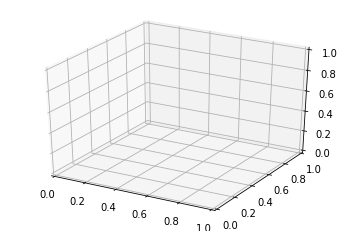

In [30]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:,0], y[:,1], z[:,2], c=y)


plt.show()

IndexError: ignored

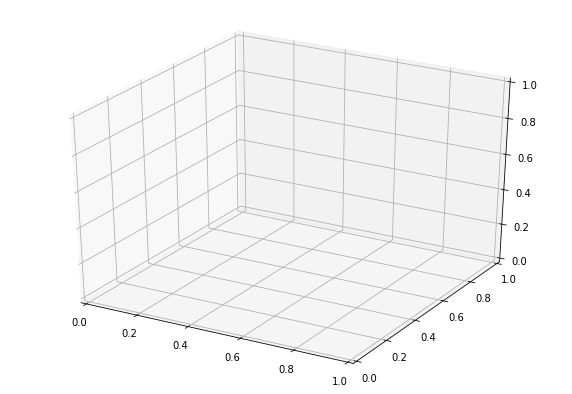

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
# Creating plot
ax.scatter3D(x[(y == 0).flatten(), 0], x[(y == 0).flatten(), 1], x[(y == 0).flatten(), 2], color="blue")
ax.scatter3D(x[(y == 1).flatten(), 0], x[(y == 1).flatten(), 1], x[(y == 1).flatten(), 2], color="red")
plt.title("simple 3D scatter plot")
# show plot
plt.show()

## Función de activación y su derivada

A continuación vamos a crear dos métodos. El primero implementará la función de activación correspondiente a la sigmoide. Esta función es necesaria para el cáculo *forward pass* de la red.  Dado un valor "x", esta función deberá cacular el varlor con respecto a la siguiente fórmula:
$$a(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}$$

El segundo método, implementará la derivada de la función anterior, necesaria para el *backward pass*. Procediendo con la derivada, obtenemos las siguiente fórmula:

$${a}' = a(1-a)$$



In [32]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [33]:
def sigmoid_out2deriv(out):
  return out * (1-out)

## Contruyendo la Red Neuronal Artificial
A continuación vamos a definir la clase Layer. Ésta implementará los 3 métodos necesarios para entrenar la red neuronal (*forward*, *backward* y *update*). Recuerda que el `__init__` debe generar los pesos ${W}$ y ${b}$  de manera aleatoria. Para ello, utiliza una distribución normal con media -0.1 y desviación estándar 0.2.

<br><rb>
Para el cáculo del *backward pass* hay que calcular las derivadas parciales del coste (error) con respecto a cada uno de los parámetros de la red (${W}$ y ${b}$). Para ello, en esta clase solamente vamos a declarar las derivadas de las capas intermedias (las derivadas parciales de la última capa, que se calculan de manera distinta, las calcularemos fuera de esta clase. Los $\delta$ de los ${W}$ se calculan en función de los $\delta$ de la capa anterior:

$$ \delta^{l-1} = W^{l}\delta^{l}\frac{\partial a^{l-1}}{\partial z^{l-1}}$$

Donde $a$ es la función de activación, $z$ es la salida de la suma ponderada de la entrada (la salida de la neurona, la regresión lineal, antes de aplicar la función de activación) y $l-1$ hace referencia a la "*Layer*" anterior.

<br><rb>
 De ahí, que el método `backward` tenga compo parámetro de entrad la variable `output_delta` (correspondiente a los $\delta$ de la capa anterior). Para el cálculo de $\delta$ de los parámetros ${W}$ la capa actual hemos de realizar dos operaciones. La primera es multiplicar el $\delta$ de la capa posterior (que proviene del parámetro de entrada `output_delta`) por la derivada de la función de activación aplicada sobre la salida de la red en el *forward pass*. La segunda operación es el producto del resultado anterior por los pesos ${W}$.

<br><rb>
Para actualizar la red (método `update`) deberemos actualizar los pesos ${W}$ con un nuevo valor de la siguiente manera:
$$W_{i}(t)\:=\:W_{i}(t-1) - \alpha(\frac{\partial error}{\partial W_{i}})$$

Siendo $(\frac{\partial error}{\partial W_{i}})$ la derivada de la función de activación aplicada sobre la salida de la red en el forward pass (calculada en el método `backward`).


In [38]:
class Layer(object):
    def __init__(self, input_dim, output_dim, activation_func, act_func_deriv):
        self.weights = (np.random.randn(input_dim, output_dim) * 0.2) - 0.1
        self.bias = (np.random.randn(1, output_dim) * 0.2) - 0.1
        self.activation_func = activation_func
        self.act_func_deriv = act_func_deriv

    def forward(self, input):
        self.input = input
        self.output = self.activation_func(np.dot(self.input, self.weights) + self.bias)
        return self.output

    def backward(self, output_delta):
        self.weight_output_delta = output_delta * self.act_func_deriv(self.output)
        return np.dot(self.weight_output_delta, self.weights.T)

    def update(self, learning_rate=0.1):
        self.weights -= np.dot(self.input.T, self.weight_output_delta) * learning_rate

## Entrenamiento de la Red

Inicializamos  los siguientes parámetros:


In [ ]:

batch_size = 10
learning_rate = 0.1

input_dim = len(x[0])
layer_1_dim = 128
layer_2_dim = 64
output_dim = 1
iterations = 1000



Creamos nuestra red neuronal de 3 capas llamando a la clase `Layer` tantas veces como sea necesario:


A continuación procederemos a entrenar nuestra red. Para ello necesitaremos crear *batches* de nuestro conjunto de datos para ir pasándoselos a la red por lotes. Para ello necesitaremos 2 bucles `for`. El primero iterará sobre un número de iteraciones (épocas), y el segundo sobre los *batches*. Se pasará cada *batch* a la red para hacer el *forward pass* y calcular la salida de la red. Después, haremos el *backward pass* (en order inverso) para actualizar los pesos de la red. Recuerda, que en la implementación de la clase `Layer`solamente se implemetó el *backward pass* de las capas intermedias. Por lo tanto, es necesario que prinero calcules el $\delta$ de la última capa para pasárselo al método `Layer.backward()`. Dicho $\delta$ es igual a la diferencia entre la salida de la red y la salida real. Finalmente actualiza cada capa con el método `Layer.update()` y computa el error acumulado por cada batch en cada época. Imprime el error cada 10 épocas por pantalla.

Iter:0 Loss:24.59334303881787
Iter:10 Loss:1.6032365513319198
Iter:20 Loss:1.584307631622783
Iter:30 Loss:1.6940336249559398
Iter:40 Loss:1.7688033286477214
Iter:50 Loss:1.8209491474085815
Iter:60 Loss:1.8637961923011483
Iter:70 Loss:1.9002079114352552
Iter:80 Loss:1.9309884748300332
Iter:90 Loss:1.95706170377783
Iter:100 Loss:1.9792883027198582
Iter:110 Loss:1.9981007686985748
Iter:120 Loss:2.013165914899971
Iter:130 Loss:2.022803634533832
Iter:140 Loss:2.0231447664269084
Iter:150 Loss:2.0097391561808062
Iter:160 Loss:1.9857793566651656
Iter:170 Loss:1.9619184841296082
Iter:180 Loss:1.9432211981511318
Iter:190 Loss:1.928309705714022
Iter:200 Loss:1.9144158819218162
Iter:210 Loss:1.8992768788211047
Iter:220 Loss:1.882870129033699
Iter:230 Loss:1.8677939744279521
Iter:240 Loss:1.8550923532018582
Iter:250 Loss:1.8447980474397812
Iter:260 Loss:1.8364947246347114
Iter:270 Loss:1.8295404079333277
Iter:280 Loss:1.823496568885885
Iter:290 Loss:1.8181657871243846
Iter:300 Loss:1.81347653543339